<a href="https://colab.research.google.com/github/iiCellxx/CSEL-303/blob/main/ACT6_ALMARIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Queuing System

In [1]:
import math

def mmc_queue(arrival_rate, service_rate, num_servers):
    rho = arrival_rate / (num_servers * service_rate)  # Utilization factor
    if rho >= 1:
        return "System is unstable (ρ ≥ 1). Increase the number of servers."

    # Probability of zero customers in the system (P0)
    sum_term = sum([(arrival_rate/service_rate)**n / math.factorial(n) for n in range(num_servers)])
    p0 = 1 / (sum_term + ((arrival_rate/service_rate)**num_servers / (math.factorial(num_servers) * (1 - rho))))

    # Expected number of customers in queue (Lq)
    lq = ( (arrival_rate/service_rate)**num_servers * rho ) / (math.factorial(num_servers) * (1 - rho)**2) * p0

    # Expected number of customers in system (L)
    l = lq + (arrival_rate / service_rate)

    # Expected waiting time in queue (Wq)
    wq = lq / arrival_rate

    # Expected waiting time in system (W)
    w = wq + (1 / service_rate)

    return {
        "Utilization Factor (ρ)": round(rho, 4),
        "P0 (No customers in system)": round(p0, 4),
        "Lq (Expected number in queue)": round(lq, 4),
        "L (Expected number in system)": round(l, 4),
        "Wq (Expected wait time in queue)": round(wq, 4),
        "W (Expected total time in system)": round(w, 4)
    }

# Example usage
arrival_rate = float(input("Enter arrival rate (λ): "))
service_rate = float(input("Enter service rate (μ): "))
num_servers = int(input("Enter number of servers (c): "))

results = mmc_queue(arrival_rate, service_rate, num_servers)
for key, value in results.items():
    print(f"{key}: {value}")


Enter arrival rate (λ): 2
Enter service rate (μ): 3
Enter number of servers (c): 4
Utilization Factor (ρ): 0.1667
P0 (No customers in system): 0.5133
Lq (Expected number in queue): 0.001
L (Expected number in system): 0.6677
Wq (Expected wait time in queue): 0.0005
W (Expected total time in system): 0.3338


# Part 2: Model Implementation

In [4]:
!pip install simpy

In [5]:
import simpy
import random
import numpy as np

# Input Parameters
ARRIVAL_RATE = 5  # Customers per minute (λ)
SERVICE_RATE = 8  # Customers served per minute (μ)
NUM_SERVERS = 2   # Number of servers (c)
SIMULATION_TIME = 100  # Total simulation time in minutes

# Global variables to track performance metrics
wait_times = []
queue_lengths = []
server_busy_time = 0

class QueueSystem:
    def __init__(self, env, num_servers, service_rate):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.service_rate = service_rate

    def serve_customer(self, customer):
        global server_busy_time
        service_time = random.expovariate(self.service_rate)
        server_busy_time += service_time
        yield self.env.timeout(service_time)

def customer_arrival(env, queue_system):
    """Simulates customer arrivals based on Poisson process."""
    while True:
        interarrival_time = random.expovariate(ARRIVAL_RATE)
        yield env.timeout(interarrival_time)

        env.process(customer_process(env, queue_system))

def customer_process(env, queue_system):
    """Handles a single customer's experience in the queue system."""
    arrival_time = env.now
    with queue_system.server.request() as request:
        yield request
        wait_times.append(env.now - arrival_time)  # Track wait time
        yield env.process(queue_system.serve_customer("Customer"))

def track_queue(env, queue_system):
    """Tracks the queue length over time."""
    while True:
        queue_lengths.append(len(queue_system.server.queue))
        yield env.timeout(1)  # Check every minute

# Run the Simulation
env = simpy.Environment()
queue_system = QueueSystem(env, NUM_SERVERS, SERVICE_RATE)
env.process(customer_arrival(env, queue_system))
env.process(track_queue(env, queue_system))
env.run(until=SIMULATION_TIME)

# Compute Performance Metrics
avg_wait_time = np.mean(wait_times)
server_utilization = server_busy_time / (NUM_SERVERS * SIMULATION_TIME)
avg_queue_length = np.mean(queue_lengths)

# Print Results
print(f"Average Wait Time: {avg_wait_time:.2f} minutes")
print(f"Server Utilization: {server_utilization:.2%}")
print(f"Average Queue Length: {avg_queue_length:.2f}")


Average Wait Time: 0.01 minutes
Server Utilization: 27.69%
Average Queue Length: 0.03


# Part 3: Experimentation and Analysis

    Arrival Rate  Service Rate  Servers  Avg Wait Time  Utilization  \
0              3             5        1           0.48         0.65   
1              3             5        2           0.02         0.28   
2              3             5        3           0.00         0.20   
3              3             8        1           0.05         0.36   
4              3             8        2           0.00         0.17   
5              3             8        3           0.00         0.13   
6              3            10        1           0.04         0.31   
7              3            10        2           0.00         0.15   
8              3            10        3           0.00         0.09   
9              5             5        1           1.61         0.91   
10             5             5        2           0.06         0.49   
11             5             5        3           0.01         0.33   
12             5             8        1           0.15         0.62   
13    

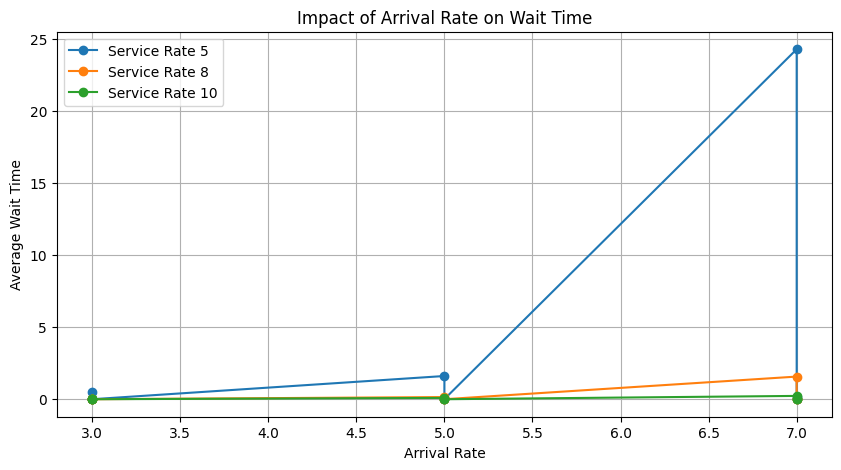

In [6]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulation function
def simulate_queue(arrival_rate, service_rate, num_servers, sim_time=100):
    wait_times = []
    queue_lengths = []
    server_busy_time = 0

    class QueueSystem:
        def __init__(self, env, num_servers, service_rate):
            self.env = env
            self.server = simpy.Resource(env, num_servers)
            self.service_rate = service_rate

        def serve_customer(self):
            nonlocal server_busy_time
            service_time = random.expovariate(self.service_rate)
            server_busy_time += service_time
            yield self.env.timeout(service_time)

    def customer_arrival(env, queue_system):
        while True:
            interarrival_time = random.expovariate(arrival_rate)
            yield env.timeout(interarrival_time)
            env.process(customer_process(env, queue_system))

    def customer_process(env, queue_system):
        arrival_time = env.now
        with queue_system.server.request() as request:
            yield request
            wait_times.append(env.now - arrival_time)
            yield env.process(queue_system.serve_customer())

    def track_queue(env, queue_system):
        while True:
            queue_lengths.append(len(queue_system.server.queue))
            yield env.timeout(1)

    env = simpy.Environment()
    queue_system = QueueSystem(env, num_servers, service_rate)
    env.process(customer_arrival(env, queue_system))
    env.process(track_queue(env, queue_system))
    env.run(until=sim_time)

    avg_wait_time = np.mean(wait_times)
    server_utilization = server_busy_time / (num_servers * sim_time)
    avg_queue_length = np.mean(queue_lengths)

    return avg_wait_time, server_utilization, avg_queue_length

# Parameter variations
arrival_rates = [3, 5, 7]  # Customers per minute
service_rates = [5, 8, 10]  # Service rate per minute
num_servers = [1, 2, 3]  # Number of servers

results = []

# Run experiments
for ar in arrival_rates:
    for sr in service_rates:
        for ns in num_servers:
            avg_wait, util, queue_len = simulate_queue(ar, sr, ns)
            results.append([ar, sr, ns, round(avg_wait, 2), round(util, 2), round(queue_len, 2)])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Arrival Rate", "Service Rate", "Servers", "Avg Wait Time", "Utilization", "Avg Queue Length"])
print(df)

# Plot results
plt.figure(figsize=(10,5))
for sr in service_rates:
    subset = df[df["Service Rate"] == sr]
    plt.plot(subset["Arrival Rate"], subset["Avg Wait Time"], marker="o", label=f"Service Rate {sr}")

plt.xlabel("Arrival Rate")
plt.ylabel("Average Wait Time")
plt.title("Impact of Arrival Rate on Wait Time")
plt.legend()
plt.grid()
plt.show()
